In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Feature Engineering

In [2]:
df = pd.read_csv("../Downloads/major-crime-indicators.csv")

#keep just 2021 data (relates best to population dataset)
df = df[(df['OCC_YEAR'] == 2021)].copy()

keep_cols = [
    'MCI_CATEGORY',
    'OFFENCE',           
    'OCC_YEAR',
    'OCC_MONTH',
    'OCC_DOW',
    'OCC_HOUR',
    'HOOD_158',
    'DIVISION',
    'LOCATION_TYPE',
    'PREMISES_TYPE',
    'LONG_WGS84',
    'LAT_WGS84'
]
df = df[keep_cols].copy()
df.shape

(34911, 12)

In [3]:
#drop null values
df = df.dropna()
df.drop(df[df['HOOD_158'] == 'NSA'].index,inplace=True)

In [4]:
df.head()

,MCI_CATEGORY,OFFENCE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_HOUR,HOOD_158,DIVISION,LOCATION_TYPE,PREMISES_TYPE,LONG_WGS84,LAT_WGS84
246675,Break and Enter,B&E,2021.0,January,Friday,0,70,D55,Bar / Restaurant,Commercial,-79.352636,43.665488
246677,Assault,Discharge Firearm - Recklessly,2021.0,January,Friday,0,111,D12,"Apartment (Rooming House, Condo)",Apartment,-79.482896,43.678799
246678,Assault,Assault With Weapon,2021.0,January,Friday,1,136,D43,"Apartment (Rooming House, Condo)",Apartment,-79.189439,43.767691
246679,Assault,Assault With Weapon,2021.0,January,Friday,2,73,D51,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,-79.371003,43.658297
246680,Assault,Assault,2021.0,January,Friday,0,124,D41,"Single Home, House (Attach Garage, Cottage, Mo...",House,-79.252632,43.734451


In [5]:
df.dtypes

MCI_CATEGORY      object
OFFENCE           object
OCC_YEAR         float64
OCC_MONTH         object
OCC_DOW           object
OCC_HOUR           int64
HOOD_158          object
DIVISION          object
LOCATION_TYPE     object
PREMISES_TYPE     object
LONG_WGS84       float64
LAT_WGS84        float64
dtype: object

In [6]:
df_merge = df.copy() 

#rename the columns
df_merge.rename(columns={
    'MCI_CATEGORY': 'Crime',
    'HOOD_158': 'Neighborhood'
}, inplace=True)

for col in ['Crime', 'NEIGHBOURHOOD_NAME', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE']:
    if col in df_merge.columns:
        df_merge[col] = df_merge[col].astype(str).str.strip()

# Ensure Neighborhood is numeric (needed for merging with sociodemographic data)
df_merge['Neighborhood'] = pd.to_numeric(df_merge['Neighborhood'], errors='coerce')


In [7]:
#create dummy variables for Crime
crime_dummy = pd.get_dummies(df_merge['Crime'], prefix='Crime', drop_first=True)

#combine with other features
df_cat = pd.concat([df_merge.drop(columns=['Crime']), crime_dummy], axis=1)

#ensure integer type for dummy features
dummy_cols = crime_dummy.columns.tolist()
df_cat[dummy_cols] = df_cat[dummy_cols].astype(int)

In [8]:
#convert the month and DOW into numeric
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}


dow_map_full = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
    'Friday': 5, 'Saturday': 6, 'Sunday': 7
}
df_cat['OCC_MONTH'] = df_cat['OCC_MONTH'].str.strip()
df_cat['OCC_DOW']   = df_cat['OCC_DOW'].str.strip()

df_cat['OCC_MONTH'] = df_cat['OCC_MONTH'].map(month_map)
df_cat['OCC_DOW']   = df_cat['OCC_DOW'].map(dow_map_full)

df_cat['OCC_MONTH'] = df_cat['OCC_MONTH'].astype('Int64')
df_cat['OCC_DOW']   = df_cat['OCC_DOW'].astype('Int64')


In [9]:
df_cat.dtypes

OFFENCE                   object
OCC_YEAR                 float64
OCC_MONTH                  Int64
OCC_DOW                    Int64
OCC_HOUR                   int64
Neighborhood               int64
DIVISION                  object
LOCATION_TYPE             object
PREMISES_TYPE             object
LONG_WGS84               float64
LAT_WGS84                float64
Crime_Auto Theft           int64
Crime_Break and Enter      int64
Crime_Robbery              int64
Crime_Theft Over           int64
dtype: object

In [10]:
pop_raw = pd.read_excel("C:/Users/Yu-Chieh Lin/Downloads/158-model - Copy.xlsx", header=None)
pop_df = pop_raw.T.reset_index(drop=True)
pop_df.columns = [
    "Neighborhood",
    "Population",
    "Avg_Age",
    "Avg_Income",
    "Low_Income_Prevalence",
    "Gini_Index",
    "Avg_Household_income",
    "%_Core_Housing_Need",
    "Avg_Owned_Shelter_Cost",
    "%_Spending_Over_30%_Income_On_Housing",
    "Avg_Rent_Shelter_Cost",
    "Workforce_Participation_Rate",
    "Unemployment_Rate",
    "%_High_School_Diploma",
    "%_Postsecondary_Diploma",
    "%_Suitable_Housing",
]
pop_df = pop_df.iloc[1:].copy()

for col in pop_df.columns:
    pop_df[col] = pd.to_numeric(pop_df[col], errors="ignore")

pop_df["Neighborhood"] = pop_df["Neighborhood"].astype(int)
crime_count = (df_cat.groupby("Neighborhood").size().reset_index(name="Crimes_Count"))
stats_df = pop_df.merge(crime_count, on="Neighborhood", how="left")
stats_df["CrimeRate_per10k"] = (stats_df["Crimes_Count"] / stats_df["Population"] * 10000)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stats_df["Neighborhood_Risk"] = scaler.fit_transform(
    stats_df[["CrimeRate_per10k"]]
)

cols_to_merge = [
    "Neighborhood",
    "Population",
    "Avg_Age",
    "Avg_Income",
    "Low_Income_Prevalence",
    "Gini_Index",
    "Avg_Household_income",
    "%_Core_Housing_Need",
    "Avg_Owned_Shelter_Cost",
    "%_Spending_Over_30%_Income_On_Housing",
    "Avg_Rent_Shelter_Cost",
    "Workforce_Participation_Rate",
    "Unemployment_Rate",
    "%_High_School_Diploma",
    "%_Postsecondary_Diploma",
    "%_Suitable_Housing",
    "Crimes_Count",
    "CrimeRate_per10k",
    "Neighborhood_Risk",
]
df_full = df_cat.merge(stats_df[cols_to_merge], on="Neighborhood", how="left")

print(df_full.shape) 
df_full.columns


C:\Users\Yu-Chieh Lin\AppData\Local\Temp\ipykernel_9052\1680284002.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  pop_df[col] = pd.to_numeric(pop_df[col], errors="ignore")


(34316, 33)


Index(['OFFENCE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DOW', 'OCC_HOUR',
       'Neighborhood', 'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE',
       'LONG_WGS84', 'LAT_WGS84', 'Crime_Auto Theft', 'Crime_Break and Enter',
       'Crime_Robbery', 'Crime_Theft Over', 'Population', 'Avg_Age',
       'Avg_Income', 'Low_Income_Prevalence', 'Gini_Index',
       'Avg_Household_income', '%_Core_Housing_Need', 'Avg_Owned_Shelter_Cost',
       '%_Spending_Over_30%_Income_On_Housing', 'Avg_Rent_Shelter_Cost',
       'Workforce_Participation_Rate', 'Unemployment_Rate',
       '%_High_School_Diploma', '%_Postsecondary_Diploma',
       '%_Suitable_Housing', 'Crimes_Count', 'CrimeRate_per10k',
       'Neighborhood_Risk'],
      dtype='object')

In [11]:
df_full.dtypes

OFFENCE                                   object
OCC_YEAR                                 float64
OCC_MONTH                                  Int64
OCC_DOW                                    Int64
OCC_HOUR                                   int64
Neighborhood                               int64
DIVISION                                  object
LOCATION_TYPE                             object
PREMISES_TYPE                             object
LONG_WGS84                               float64
LAT_WGS84                                float64
Crime_Auto Theft                           int64
Crime_Break and Enter                      int64
Crime_Robbery                              int64
Crime_Theft Over                           int64
Population                               float64
Avg_Age                                  float64
Avg_Income                               float64
Low_Income_Prevalence                    float64
Gini_Index                               float64
Avg_Household_income

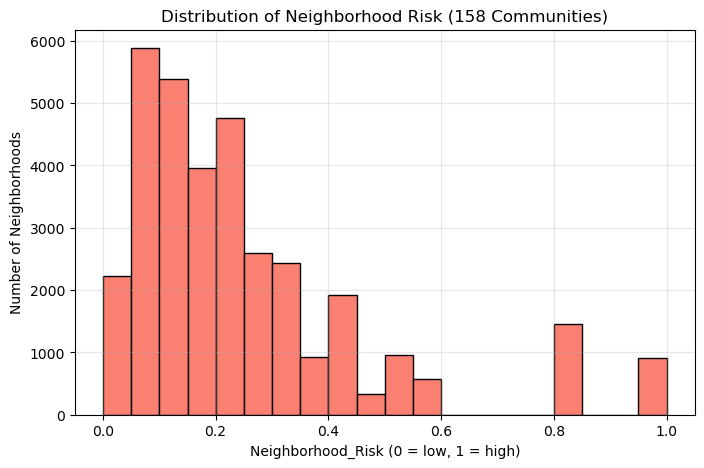

In [12]:
plt.figure(figsize=(8,5))
plt.hist(df_full['Neighborhood_Risk'], bins=20, edgecolor='black', color='salmon')
plt.title('Distribution of Neighborhood Risk (158 Communities)')
plt.xlabel('Neighborhood_Risk (0 = low, 1 = high)')
plt.ylabel('Number of Neighborhoods')
plt.grid(alpha=0.3)
plt.show()

In [13]:
# define crime risk threshold
mean_risk = df_full['Neighborhood_Risk'].mean()
std_risk = df_full['Neighborhood_Risk'].std()
threshold = mean_risk + std_risk

print(f"Mean Risk: {mean_risk:.3f}")
print(f"Std Dev: {std_risk:.3f}")
print(f"Suggested High-Risk Threshold: {threshold:.3f}")

df_full['High_Risk_Neighborhood'] = np.where(df_full['Neighborhood_Risk'] >= threshold, 1, 0)

ratio = df_full['High_Risk_Neighborhood'].mean() * 100
print(f"High-risk neighborhoods: {ratio:.1f}% of total")

Mean Risk: 0.253
Std Dev: 0.216
Suggested High-Risk Threshold: 0.470
High-risk neighborhoods: 12.3% of total


In [14]:
#merged_df['Neighborhood'] = merged_df['Neighborhood_Risk']
#merged_df = merged_df.drop('Neighborhood_Risk', axis = 1)
merged_df = df_full.copy()
merged_df = merged_df.drop('Crimes_Count', axis = 1)
merged_df = merged_df.drop('CrimeRate_per10k', axis = 1)
#merged_df = merged_df.rename(columns={'Neighborhood': 'Neighborhood_Risk'})

merged_df['Neighborhood_Risk'] = np.where(merged_df['Neighborhood_Risk'] >= 0.3, 1, 0)
merged_df = merged_df.rename(columns={'Neighborhood_Risk': 'High_Risk_Neighborhood'})

In [15]:
merged_df

,OFFENCE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_HOUR,Neighborhood,DIVISION,LOCATION_TYPE,PREMISES_TYPE,LONG_WGS84,...,Avg_Owned_Shelter_Cost,%_Spending_Over_30%_Income_On_Housing,Avg_Rent_Shelter_Cost,Workforce_Participation_Rate,Unemployment_Rate,%_High_School_Diploma,%_Postsecondary_Diploma,%_Suitable_Housing,High_Risk_Neighborhood,High_Risk_Neighborhood
0,B&E,2021.0,1,5,0,70,D55,Bar / Restaurant,Commercial,-79.352636,...,2248.0,34.4,1582.0,72.7,13.0,0.186348,0.669179,0.934304,0,0
1,Discharge Firearm - Recklessly,2021.0,1,5,0,111,D12,"Apartment (Rooming House, Condo)",Apartment,-79.482896,...,1654.0,32.9,1111.0,56.8,14.2,0.297990,0.434426,0.861096,0,0
2,Assault With Weapon,2021.0,1,5,1,136,D43,"Apartment (Rooming House, Condo)",Apartment,-79.189439,...,1806.0,29.0,982.0,57.4,16.9,0.307140,0.521124,0.848723,0,0
3,Assault With Weapon,2021.0,1,5,2,73,D51,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,-79.371003,...,2270.0,39.5,1376.0,72.3,14.6,0.183233,0.720382,0.913469,1,1
4,Assault,2021.0,1,5,0,124,D41,"Single Home, House (Attach Garage, Cottage, Mo...",House,-79.252632,...,1732.0,23.9,1016.0,56.3,18.4,0.289845,0.507057,0.830046,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34311,Assault With Weapon,2021.0,1,5,12,3,D23,"Single Home, House (Attach Garage, Cottage, Mo...",House,-79.578025,...,1712.0,30.9,1244.0,59.8,16.6,0.284431,0.494012,0.845679,0,0
34312,Assault,2021.0,1,5,12,3,D23,"Single Home, House (Attach Garage, Cottage, Mo...",House,-79.578025,...,1712.0,30.9,1244.0,59.8,16.6,0.284431,0.494012,0.845679,0,0
34313,Assault Bodily Harm,2021.0,1,5,0,24,D31,"Apartment (Rooming House, Condo)",Apartment,-79.509643,...,1386.0,28.2,1161.0,52.8,19.5,0.321376,0.349373,0.711618,0,0
34314,Assault,2021.0,1,5,0,24,D31,"Apartment (Rooming House, Condo)",Apartment,-79.509643,...,1386.0,28.2,1161.0,52.8,19.5,0.321376,0.349373,0.711618,0,0


In [16]:
categorical_cols = ['DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'OFFENCE']
merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)
print(merged_df.shape)
merged_df

(34316, 145)


,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_HOUR,Neighborhood,LONG_WGS84,LAT_WGS84,Crime_Auto Theft,Crime_Break and Enter,Crime_Robbery,...,OFFENCE_Theft From Motor Vehicle Over,OFFENCE_Theft Of Motor Vehicle,OFFENCE_Theft Of Utilities Over,OFFENCE_Theft Over,OFFENCE_Theft Over - Bicycle,OFFENCE_Theft Over - Distraction,OFFENCE_Theft Over - Shoplifting,OFFENCE_Traps Likely Cause Bodily Harm,OFFENCE_Unlawfully In Dwelling-House,OFFENCE_Use Firearm / Immit Commit Off
0,2021.0,1,5,0,70,-79.352636,43.665488,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2021.0,1,5,0,111,-79.482896,43.678799,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2021.0,1,5,1,136,-79.189439,43.767691,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,2021.0,1,5,2,73,-79.371003,43.658297,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,2021.0,1,5,0,124,-79.252632,43.734451,0,0,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34311,2021.0,1,5,12,3,-79.578025,43.734960,0,0,0,...,False,False,False,False,False,False,False,False,False,False
34312,2021.0,1,5,12,3,-79.578025,43.734960,0,0,0,...,False,False,False,False,False,False,False,False,False,False
34313,2021.0,1,5,0,24,-79.509643,43.760476,0,0,0,...,False,False,False,False,False,False,False,False,False,False
34314,2021.0,1,5,0,24,-79.509643,43.760476,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## Classification model 

## Classification model - day and night

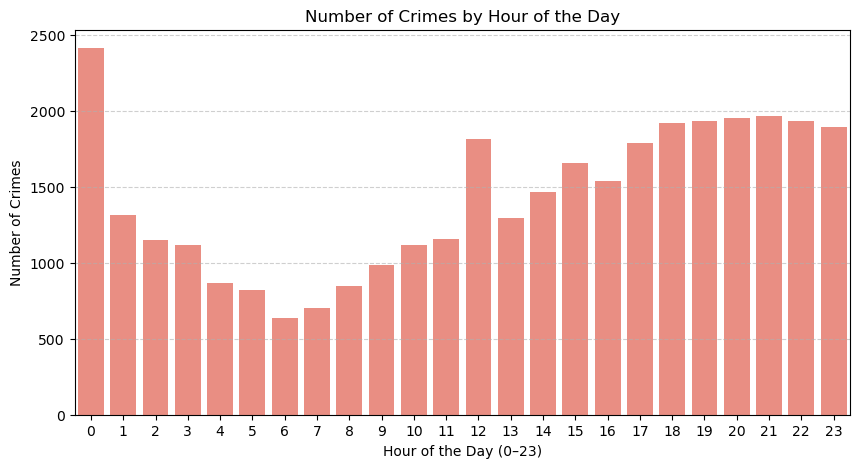

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='OCC_HOUR', data=merged_df, color='salmon')
plt.title("Number of Crimes by Hour of the Day")
plt.xlabel("Hour of the Day (0–23)")
plt.ylabel("Number of Crimes")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

C:\Users\Yu-Chieh Lin\AppData\Local\Temp\ipykernel_9052\2395213540.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Day_Night', data=merged_df, order=['Day','Night'], palette='YlOrRd')


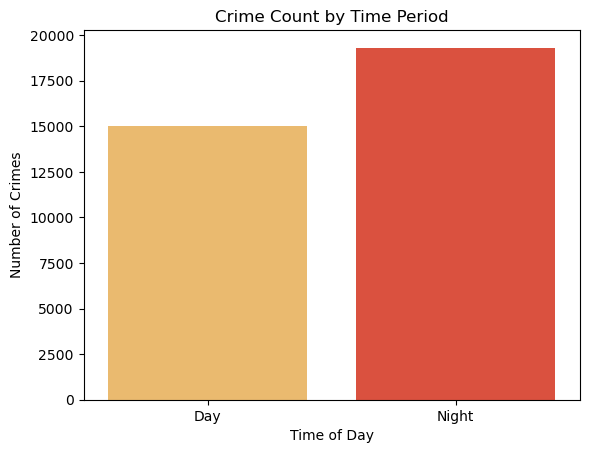

In [18]:
def day_or_night(hour):
    if 6 <= hour < 18:
        return "Day"      # 6:00 AM to 6:00 PM
    else:
        return "Night"    # 6:00 PM to 6:00 AM

merged_df['Day_Night'] = merged_df['OCC_HOUR'].apply(day_or_night)
sns.countplot(x='Day_Night', data=merged_df, order=['Day','Night'], palette='YlOrRd')
plt.title("Crime Count by Time Period")
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes")
plt.show()

In [19]:
merged_df['is_weekend'] = merged_df['OCC_DOW'].isin(['Saturday', 'Sunday']).astype(int)

In [20]:
merged_df.dtypes

OCC_YEAR                                  float64
OCC_MONTH                                   Int64
OCC_DOW                                     Int64
OCC_HOUR                                    int64
Neighborhood                                int64
                                           ...   
OFFENCE_Traps Likely Cause Bodily Harm       bool
OFFENCE_Unlawfully In Dwelling-House         bool
OFFENCE_Use Firearm / Immit Commit Off       bool
Day_Night                                  object
is_weekend                                  int64
Length: 147, dtype: object

In [21]:
merged_df.head()

,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_HOUR,Neighborhood,LONG_WGS84,LAT_WGS84,Crime_Auto Theft,Crime_Break and Enter,Crime_Robbery,...,OFFENCE_Theft Of Utilities Over,OFFENCE_Theft Over,OFFENCE_Theft Over - Bicycle,OFFENCE_Theft Over - Distraction,OFFENCE_Theft Over - Shoplifting,OFFENCE_Traps Likely Cause Bodily Harm,OFFENCE_Unlawfully In Dwelling-House,OFFENCE_Use Firearm / Immit Commit Off,Day_Night,is_weekend
0,2021.0,1,5,0,70,-79.352636,43.665488,0,1,0,...,False,False,False,False,False,False,False,False,Night,0
1,2021.0,1,5,0,111,-79.482896,43.678799,0,0,0,...,False,False,False,False,False,False,False,False,Night,0
2,2021.0,1,5,1,136,-79.189439,43.767691,0,0,0,...,False,False,False,False,False,False,False,False,Night,0
3,2021.0,1,5,2,73,-79.371003,43.658297,0,0,0,...,False,False,False,False,False,False,False,False,Night,0
4,2021.0,1,5,0,124,-79.252632,43.734451,0,0,0,...,False,False,False,False,False,False,False,False,Night,0


In [22]:
cols_to_remove = [c for c in merged_df.columns 
                  if c.startswith("Crime_") or c.startswith("OFFENCE_")]

merged_df["Day_Night"] = merged_df["Day_Night"].map({"Day": 0, "Night": 1})
X = merged_df.drop(columns=cols_to_remove +['Day_Night']+['OCC_HOUR'])
y = merged_df["Day_Night"]

### Logistic Regression

Train Accuracy:      0.5621
Validation Accuracy: 0.5632
Test Accuracy:       0.5412


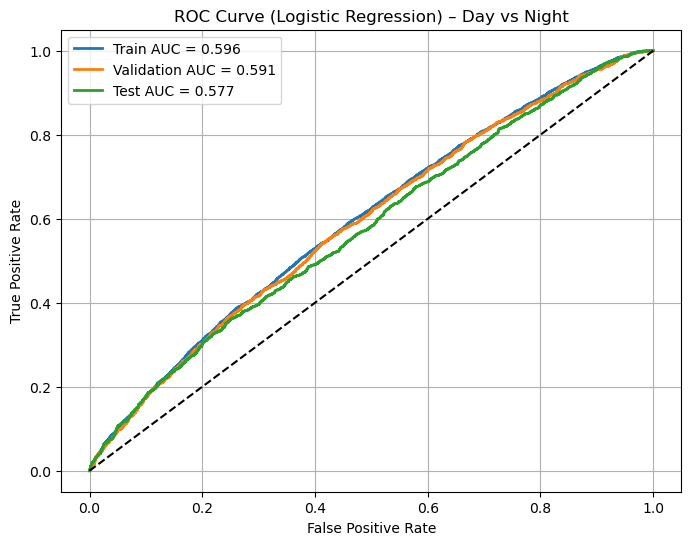

In [400]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs"
)

model.fit(X_train_scaled, y_train)

train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
val_acc   = accuracy_score(y_val, model.predict(X_val_scaled))
test_acc  = accuracy_score(y_test, model.predict(X_test_scaled))

print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")


train_prob = model.predict_proba(X_train_scaled)[:, 1]
val_prob   = model.predict_proba(X_val_scaled)[:, 1]
test_prob  = model.predict_proba(X_test_scaled)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, train_prob)
fpr_val, tpr_val, _     = roc_curve(y_val, val_prob)
fpr_test, tpr_test, _   = roc_curve(y_test, test_prob)

auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))

plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}", linewidth=2)
plt.plot(fpr_val, tpr_val, label=f"Validation AUC = {auc_val:.3f}", linewidth=2)
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {auc_test:.3f}", linewidth=2)

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression) – Day vs Night")
plt.legend()
plt.grid(True)
plt.show()

coef = model.coef_[0]              
feature_names = X.columns


### randomized search + grid search + rf

In [348]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", 0.5]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params from Randomized Search:")
print(random_search.best_params_)


C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
9 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Yu-Chieh

Best params from Randomized Search:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': None}


In [349]:
from sklearn.model_selection import GridSearchCV

best_params = random_search.best_params_

grid_params = {
    "n_estimators": [best_params["n_estimators"] - 100,
                     best_params["n_estimators"],
                     best_params["n_estimators"] + 100],
    "max_depth": [best_params["max_depth"],
                  None if best_params["max_depth"] is None else best_params["max_depth"] + 10],
    "min_samples_split": [best_params["min_samples_split"], 5],
    "min_samples_leaf": [best_params["min_samples_leaf"], 2],
    "max_features": [best_params["max_features"]]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid=grid_params,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest params from Grid Search:")
print(grid_search.best_params_)


Best params from Grid Search:
{'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}



Train Accuracy (RF): 0.9667
Validation Accuracy (RF): 0.6299
Test Accuracy (RF): 0.6313


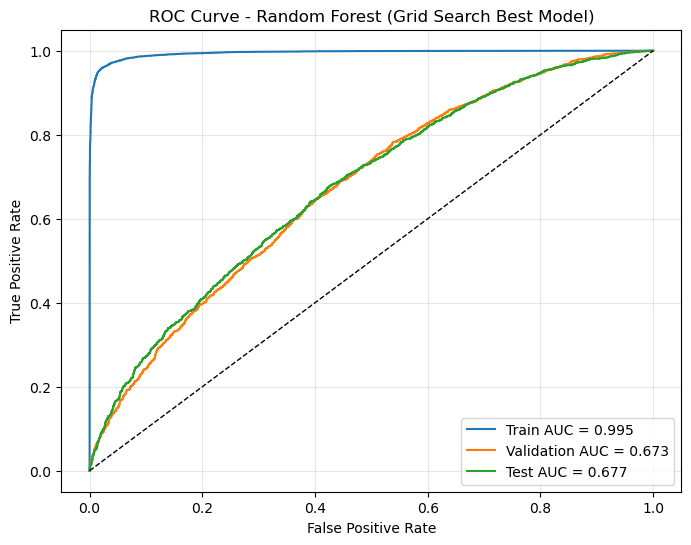

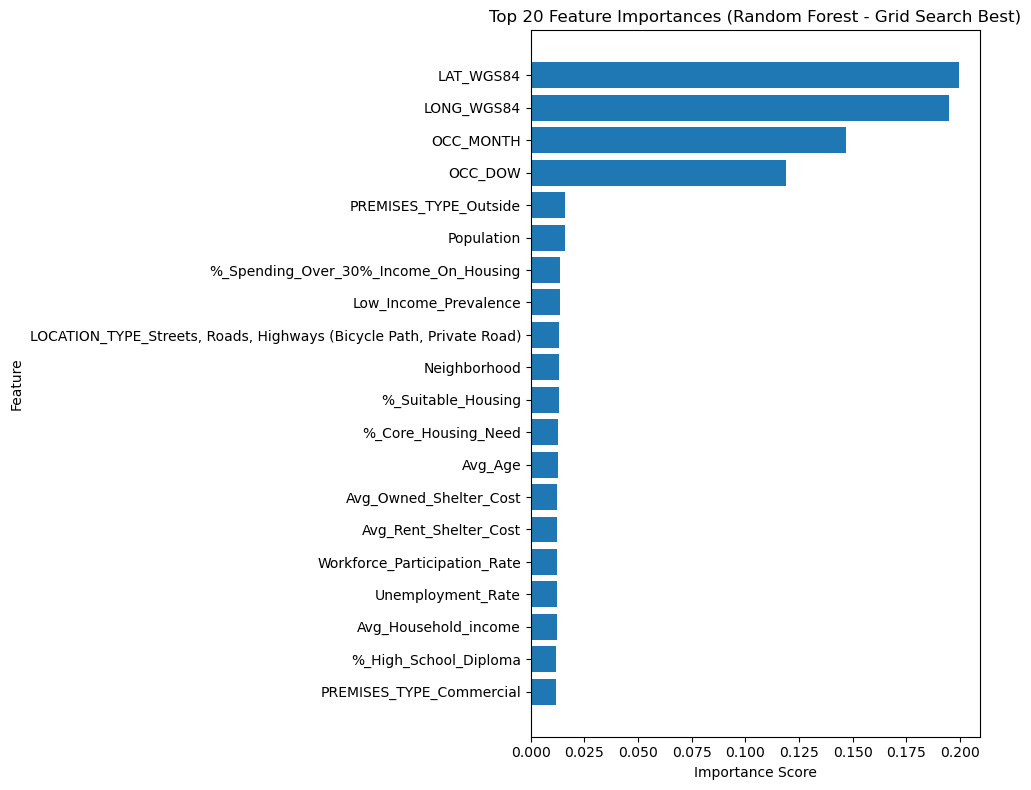

In [410]:
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, classification_report

val_pred = best_rf.predict(X_val)
test_pred = best_rf.predict(X_test)
train_pred = best_rf.predict(X_train)

print(f"\nTrain Accuracy (RF): {accuracy_score(y_train, train_pred):.4f}")
print(f"Validation Accuracy (RF): {accuracy_score(y_val, val_pred):.4f}")
print(f"Test Accuracy (RF): {accuracy_score(y_test, test_pred):.4f}")

y_train_prob = best_rf.predict_proba(X_train)[:, 1]
y_val_prob   = best_rf.predict_proba(X_val)[:, 1]
y_test_prob  = best_rf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=best_rf.classes_[1])
fpr_val,   tpr_val,   _ = roc_curve(y_val,   y_val_prob,   pos_label=best_rf.classes_[1])
fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_test_prob,  pos_label=best_rf.classes_[1])

auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))

plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_val,   tpr_val,   label=f"Validation AUC = {auc_val:.3f}")
plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.title("ROC Curve - Random Forest (Grid Search Best Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20

plt.figure(figsize=(10, 8))
plt.barh(
    X.columns[indices][:top_k][::-1], 
    importances[indices][:top_k][::-1]
)

plt.title("Top 20 Feature Importances (Random Forest - Grid Search Best)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Train Accuracy (Improved RF): 0.7305
Validation Accuracy (Improved RF): 0.5803
Test Accuracy (Improved RF): 0.5715


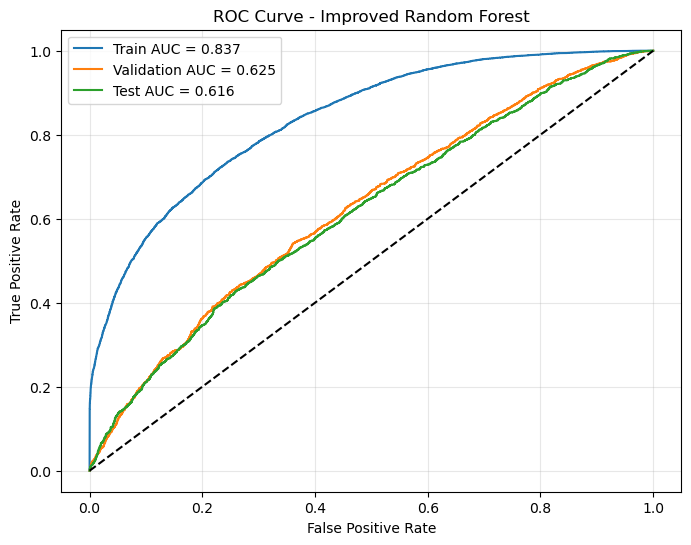

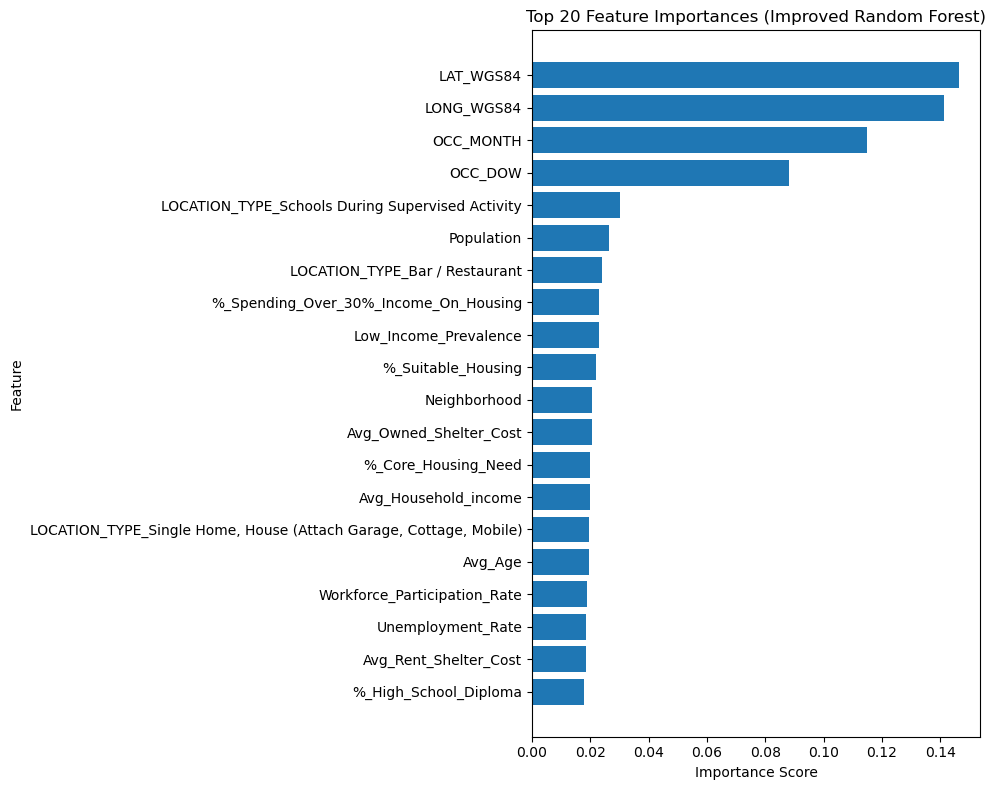

In [23]:
### using grid search range to rerun model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


improved_rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=15,                 
    min_samples_split=3,
    min_samples_leaf=3,
    max_features=0.5,
    class_weight="balanced",
    random_state=42
)

improved_rf.fit(X_train, y_train)

train_pred = improved_rf.predict(X_train)
val_pred   = improved_rf.predict(X_val)
test_pred  = improved_rf.predict(X_test)

print(f"\nTrain Accuracy (Improved RF): {accuracy_score(y_train, train_pred):.4f}")
print(f"Validation Accuracy (Improved RF): {accuracy_score(y_val, val_pred):.4f}")
print(f"Test Accuracy (Improved RF): {accuracy_score(y_test, test_pred):.4f}")


y_train_prob = improved_rf.predict_proba(X_train)[:, 1]
y_val_prob   = improved_rf.predict_proba(X_val)[:, 1]
y_test_prob  = improved_rf.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=improved_rf.classes_[1])
fpr_val,   tpr_val,   _ = roc_curve(y_val,   y_val_prob,   pos_label=improved_rf.classes_[1])
fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_test_prob,  pos_label=improved_rf.classes_[1])

auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_val,   tpr_val,   label=f"Validation AUC = {auc_val:.3f}")
plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Improved Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


importances = improved_rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20
plt.figure(figsize=(10, 8))
plt.barh(
    X_train.columns[indices][:top_k][::-1],
    importances[indices][:top_k][::-1]
)

plt.title("Top 20 Feature Importances (Improved Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Fine tuned GBM

In [351]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

gbm = GradientBoostingClassifier(random_state=42)

gbm_param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

gbm_random = RandomizedSearchCV(
    gbm,
    gbm_param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1
)

gbm_random.fit(X_train, y_train)

print("Best GBM params (Randomized Search):")
print(gbm_random.best_params_)

Best GBM params (Randomized Search):
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}


In [352]:
best_gbm_params = gbm_random.best_params_

gbm_grid_params = {
    "n_estimators": [best_gbm_params["n_estimators"] - 50,
                     best_gbm_params["n_estimators"],
                     best_gbm_params["n_estimators"] + 50],
    "learning_rate": [best_gbm_params["learning_rate"] / 2,
                      best_gbm_params["learning_rate"],
                      best_gbm_params["learning_rate"] * 2],
    "max_depth": [best_gbm_params["max_depth"], best_gbm_params["max_depth"] + 1],
}

gbm_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gbm_grid_params,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

gbm_grid.fit(X_train, y_train)

print("\nBest GBM params (Grid Search):")
print(gbm_grid.best_params_)


Best GBM params (Grid Search):
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 350}



Validation Accuracy (GBM): 0.6147
Test Accuracy (GBM): 0.6066


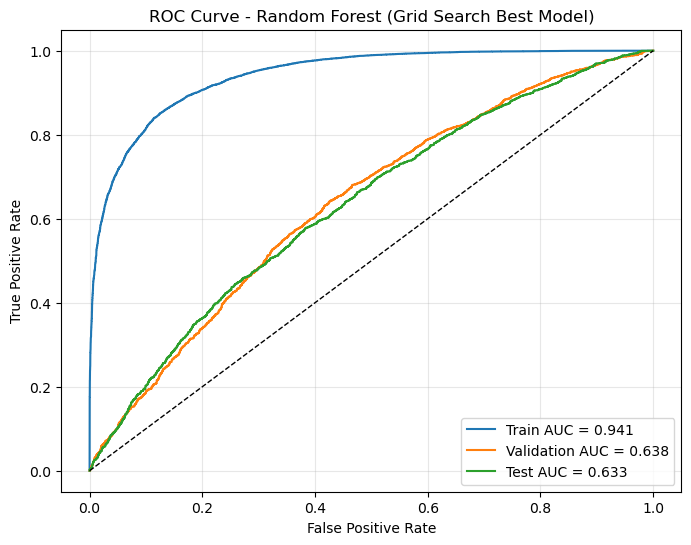

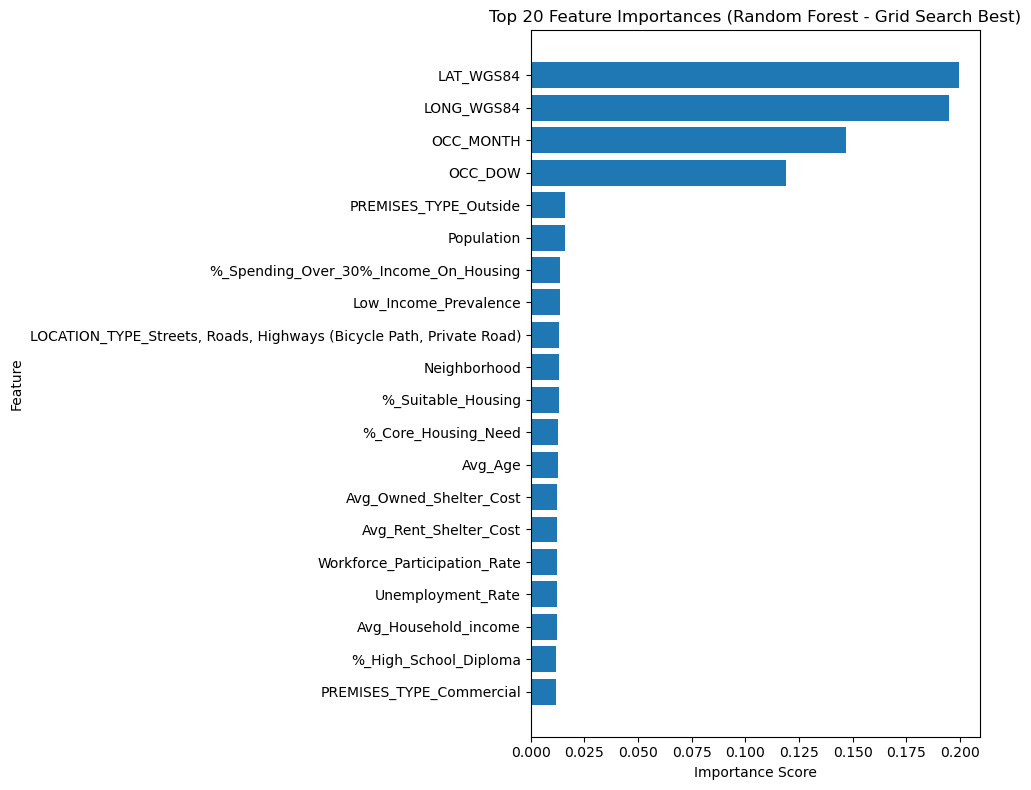

In [414]:
best_gbm = gbm_grid.best_estimator_
best_gbm.fit(X_train, y_train)

val_pred_gbm = best_gbm.predict(X_val)
test_pred_gbm = best_gbm.predict(X_test)

print(f"\nValidation Accuracy (GBM): {accuracy_score(y_val, val_pred_gbm):.4f}")
print(f"Test Accuracy (GBM): {accuracy_score(y_test, test_pred_gbm):.4f}")


y_train_prob = best_gbm.predict_proba(X_train)[:, 1]
y_val_prob   = best_gbm.predict_proba(X_val)[:, 1]
y_test_prob  = best_gbm.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=best_rf.classes_[1])
fpr_val,   tpr_val,   _ = roc_curve(y_val,   y_val_prob,   pos_label=best_rf.classes_[1])
fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_test_prob,  pos_label=best_rf.classes_[1])

auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)


plt.figure(figsize=(8, 6))

plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_val,   tpr_val,   label=f"Validation AUC = {auc_val:.3f}")
plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.title("ROC Curve - Random Forest (Grid Search Best Model)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20

plt.figure(figsize=(10, 8))
plt.barh(
    X.columns[indices][:top_k][::-1], 
    importances[indices][:top_k][::-1]
)

plt.title("Top 20 Feature Importances (GBM - Grid Search Best)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Train Accuracy: 0.6306
Validation Accuracy: 0.5904
Test Accuracy: 0.5791


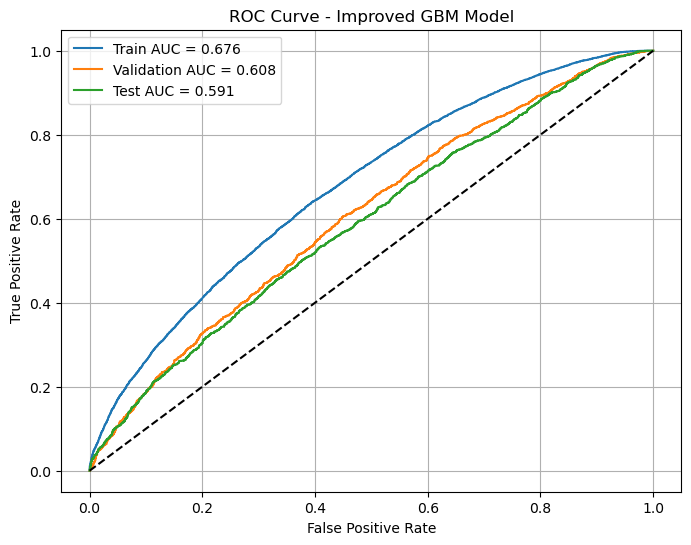

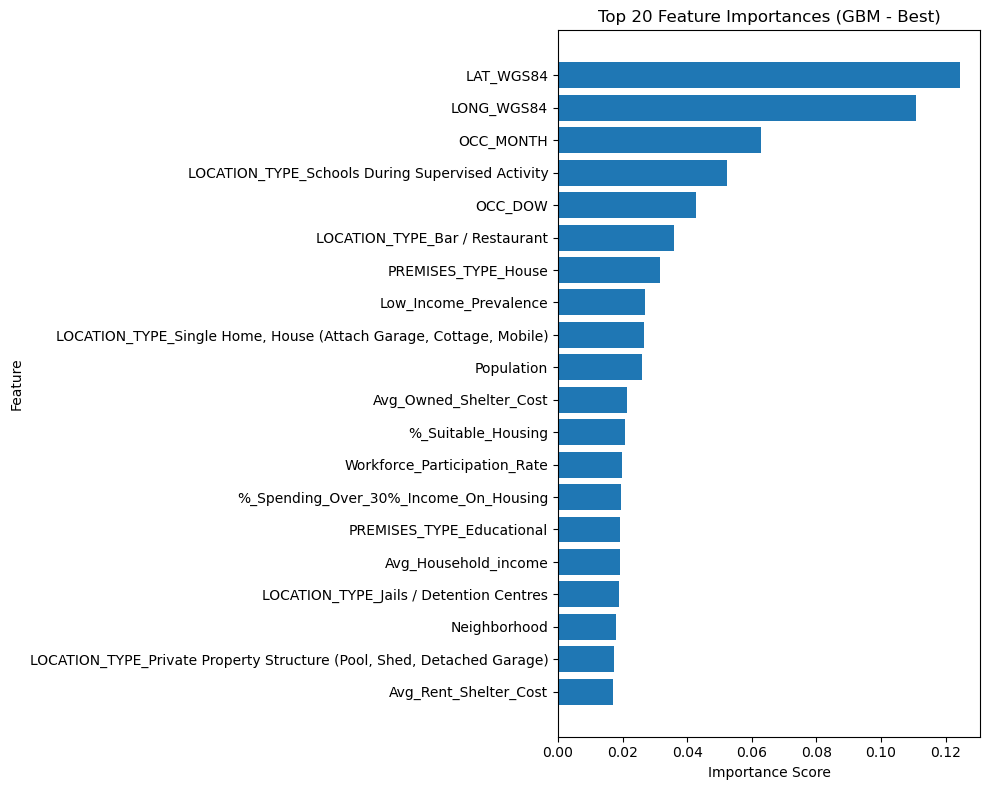

In [24]:
### using grid search to do the GBM again

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

better_gbm = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=500,
    subsample=0.7,
    max_features=0.6,
    random_state=42
)


better_gbm.fit(X_train, y_train)

train_pred = better_gbm.predict(X_train)
val_pred   = better_gbm.predict(X_val)
test_pred  = better_gbm.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")


y_train_prob = better_gbm.predict_proba(X_train)[:, 1]
y_val_prob   = better_gbm.predict_proba(X_val)[:, 1]
y_test_prob  = better_gbm.predict_proba(X_test)[:, 1]

pos_label = better_gbm.classes_[1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob, pos_label=pos_label)
fpr_val,   tpr_val,   _ = roc_curve(y_val,   y_val_prob,   pos_label=pos_label)
fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_test_prob,  pos_label=pos_label)

auc_train = auc(fpr_train, tpr_train)
auc_val   = auc(fpr_val, tpr_val)
auc_test  = auc(fpr_test, tpr_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {auc_train:.3f}")
plt.plot(fpr_val,   tpr_val,   label=f"Validation AUC = {auc_val:.3f}")
plt.plot(fpr_test,  tpr_test,  label=f"Test AUC = {auc_test:.3f}")
plt.plot([0, 1], [0, 1], 'k--')

plt.title("ROC Curve - Improved GBM Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

importances = better_gbm.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 20

plt.figure(figsize=(10, 8))
plt.barh(
    X.columns[indices][:top_k][::-1], 
    importances[indices][:top_k][::-1]
)

plt.title("Top 20 Feature Importances (GBM - Best)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Classification Model - Violent V.S. Non-Violent

In [25]:
merged_df.columns.tolist()

['OCC_YEAR',
 'OCC_MONTH',
 'OCC_DOW',
 'OCC_HOUR',
 'Neighborhood',
 'LONG_WGS84',
 'LAT_WGS84',
 'Crime_Auto Theft',
 'Crime_Break and Enter',
 'Crime_Robbery',
 'Crime_Theft Over',
 'Population',
 'Avg_Age',
 'Avg_Income',
 'Low_Income_Prevalence',
 'Gini_Index',
 'Avg_Household_income',
 '%_Core_Housing_Need',
 'Avg_Owned_Shelter_Cost',
 '%_Spending_Over_30%_Income_On_Housing',
 'Avg_Rent_Shelter_Cost',
 'Workforce_Participation_Rate',
 'Unemployment_Rate',
 '%_High_School_Diploma',
 '%_Postsecondary_Diploma',
 '%_Suitable_Housing',
 'High_Risk_Neighborhood',
 'High_Risk_Neighborhood',
 'DIVISION_D12',
 'DIVISION_D13',
 'DIVISION_D14',
 'DIVISION_D22',
 'DIVISION_D23',
 'DIVISION_D31',
 'DIVISION_D32',
 'DIVISION_D33',
 'DIVISION_D41',
 'DIVISION_D42',
 'DIVISION_D43',
 'DIVISION_D51',
 'DIVISION_D52',
 'DIVISION_D53',
 'DIVISION_D55',
 'LOCATION_TYPE_Bank And Other Financial Institutions (Money Mart, Tsx)',
 'LOCATION_TYPE_Bar / Restaurant',
 'LOCATION_TYPE_Commercial Dwelling Uni

In [26]:
#define violent crime
import numpy as np

offence_cols = [col for col in merged_df.columns if col.startswith("OFFENCE_")]

violent_keywords = [
    "Assault", "Bodily Harm", "Firearm", "Weapon", "Robbery", "Threat"
]


merged_df["Violent"] = 0


for col in offence_cols:
    if any(keyword in col for keyword in violent_keywords):
        merged_df.loc[merged_df[col] == 1, "Violent"] = 1

C:\Users\Yu-Chieh Lin\AppData\Local\Temp\ipykernel_9052\942166449.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Violent", data=merged_df, palette="Set2")


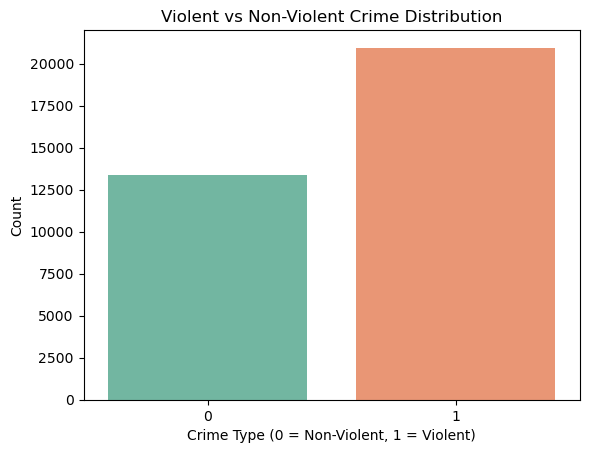

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Violent", data=merged_df, palette="Set2")
plt.title("Violent vs Non-Violent Crime Distribution")
plt.xlabel("Crime Type (0 = Non-Violent, 1 = Violent)")
plt.ylabel("Count")
plt.show()

In [27]:
cols_to_drop = [c for c in merged_df.columns 
                if c.startswith("OFFENCE_") or c.startswith("Crime_")]

X = merged_df.drop(columns=cols_to_drop + ["Violent"])
y = merged_df["Violent"]

In [28]:
from sklearn.model_selection import train_test_split

# 70%/30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

log_model = LogisticRegression(max_iter=500, class_weight="balanced")
log_model.fit(X_train, y_train)

# Predictions
train_prob = log_model.predict_proba(X_train)[:,1]
val_prob   = log_model.predict_proba(X_val)[:,1]
test_prob  = log_model.predict_proba(X_test)[:,1]

# Accuracy
print("Logistic Regression Accuracy:")
print("Train:", accuracy_score(y_train, log_model.predict(X_train)))
print("Val  :", accuracy_score(y_val, log_model.predict(X_val)))
print("Test :", accuracy_score(y_test, log_model.predict(X_test)))

# AUC
print("\nLogistic Regression AUC:")
print("Train:", roc_auc_score(y_train, train_prob))
print("Val  :", roc_auc_score(y_val, val_prob))
print("Test :", roc_auc_score(y_test, test_prob))

Logistic Regression Accuracy:
Train: 0.5844885724990633
Val  : 0.5900524577423742
Test : 0.583916083916084

Logistic Regression AUC:
Train: 0.62773231508535
Val  : 0.6377961784814293
Test : 0.6275195364457444


C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Fine Tune RF

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

rf_param_dist = {
    "n_estimators": randint(200, 600),
    "max_depth": randint(5, 40),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None]
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

rf_random = RandomizedSearchCV(
    rf,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)

print("Best params from Randomized Search (RF):")
print(rf_random.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params from Randomized Search (RF):
{'max_depth': 33, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 208}


In [32]:
from sklearn.model_selection import GridSearchCV
best_rf = rf_random.best_params_

rf_param_grid = {
    "n_estimators": [best_rf["n_estimators"] - 50,
                     best_rf["n_estimators"],
                     best_rf["n_estimators"] + 50],
    "max_depth": [best_rf["max_depth"] - 5,
                  best_rf["max_depth"],
                  best_rf["max_depth"] + 5],
    "min_samples_split": [best_rf["min_samples_split"] - 1,
                          best_rf["min_samples_split"],
                          best_rf["min_samples_split"] + 1],
    "min_samples_leaf": [best_rf["min_samples_leaf"] - 1,
                         best_rf["min_samples_leaf"],
                         best_rf["min_samples_leaf"] + 1],
    "max_features": [best_rf["max_features"]]
}

rf_grid = GridSearchCV(
    rf,
    param_grid=rf_param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best parameters from Grid Search (RF):")
print(rf_grid.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "C:\Users\Yu-Chieh Lin\anaconda3\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Yu-Ch

Best parameters from Grid Search (RF):
{'max_depth': 28, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 258}


RF AUC:
Train: 0.9965216373203026
Val  : 0.8359121933784764
Test : 0.8298162734155385
Random Forest Accuracy:
Train Accuracy: 0.9697
Validation Accuracy: 0.7661
Test Accuracy:       0.7720


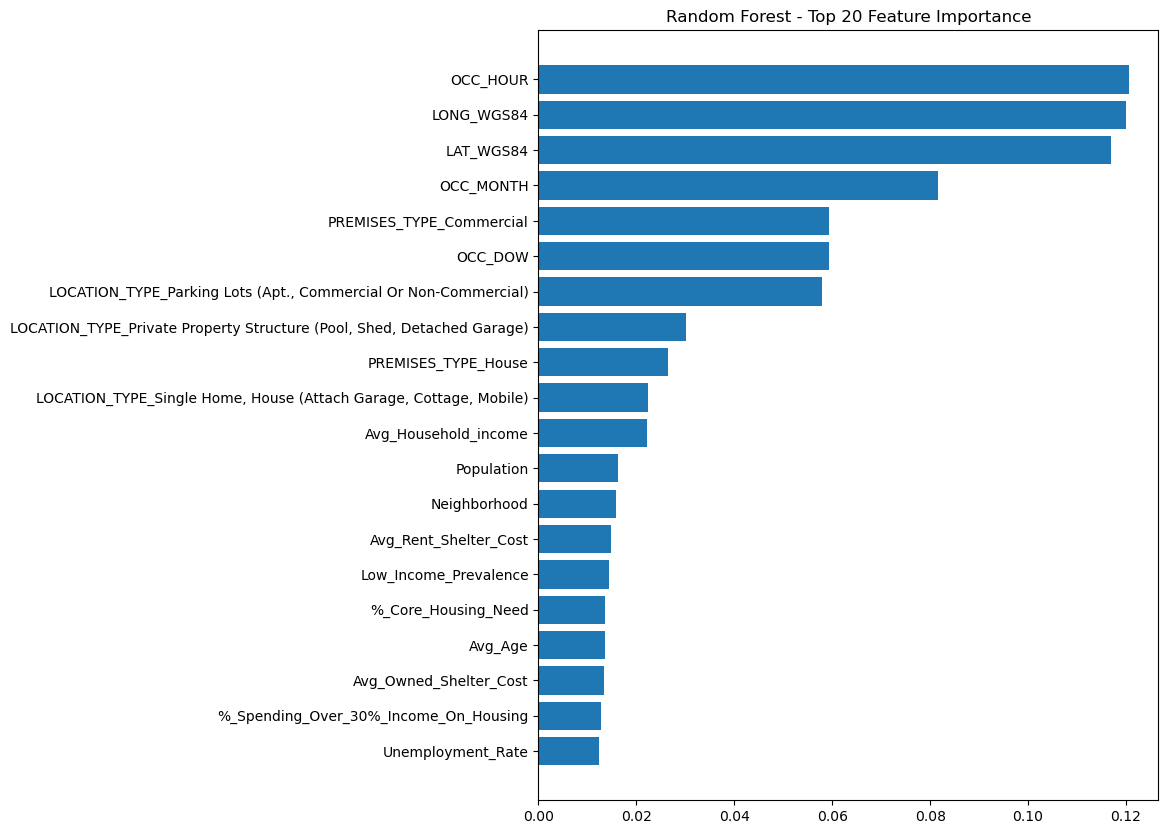

In [42]:
best_rf_model = rf_grid.best_estimator_

train_prob = best_rf_model.predict_proba(X_train)[:,1]
val_prob   = best_rf_model.predict_proba(X_val)[:,1]
test_prob  = best_rf_model.predict_proba(X_test)[:,1]

print("RF AUC:")
print("Train:", roc_auc_score(y_train, train_prob))
print("Val  :", roc_auc_score(y_val, val_prob))
print("Test :", roc_auc_score(y_test, test_prob))

rf_train_pred  = best_rf_model.predict(X_train)
rf_val_pred  = best_rf_model.predict(X_val)
rf_test_pred = best_rf_model.predict(X_test)

rf_train_acc  = accuracy_score(y_train, rf_train_pred)
rf_val_acc  = accuracy_score(y_val, rf_val_pred)
rf_test_acc = accuracy_score(y_test, rf_test_pred)

print("Random Forest Accuracy:")
print(f"Train Accuracy: {rf_train_acc:.4f}")
print(f"Validation Accuracy: {rf_val_acc:.4f}")
print(f"Test Accuracy:       {rf_test_acc:.4f}")

importances = best_rf_model.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,10))
plt.barh(X.columns[idx][:20][::-1], importances[idx][:20][::-1])
plt.title("Random Forest - Top 20 Feature Importance")
plt.show()

RF AUC:
Train: 0.8485848567780548
Val  : 0.8074004665405249
Test : 0.8011060301996182

Random Forest Accuracy:
Train Accuracy: 0.7738
Validation Accuracy: 0.7447
Test Accuracy:       0.7378


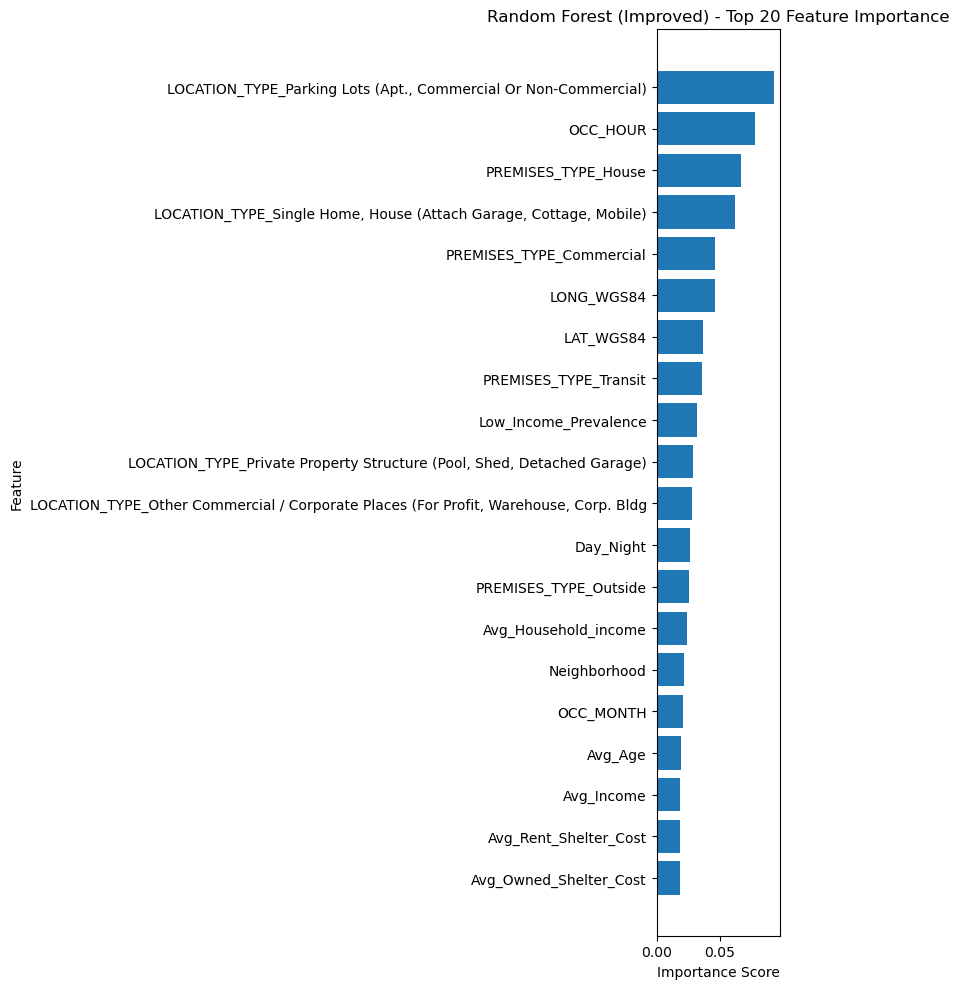

In [39]:
### using grid search parameters retrain model
improved_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42
)

# Train model
improved_rf.fit(X_train, y_train)


train_prob = improved_rf.predict_proba(X_train)[:, 1]
val_prob   = improved_rf.predict_proba(X_val)[:, 1]
test_prob  = improved_rf.predict_proba(X_test)[:, 1]

print("RF AUC:")
print("Train:", roc_auc_score(y_train, train_prob))
print("Val  :", roc_auc_score(y_val, val_prob))
print("Test :", roc_auc_score(y_test, test_prob))


train_pred = improved_rf.predict(X_train)
val_pred   = improved_rf.predict(X_val)
test_pred  = improved_rf.predict(X_test)

print("\nRandom Forest Accuracy:")
print(f"Train Accuracy: {accuracy_score(y_train, train_pred):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, val_pred):.4f}")
print(f"Test Accuracy:       {accuracy_score(y_test, test_pred):.4f}")

importances = improved_rf.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 10))
plt.barh(X.columns[idx][:20][::-1], importances[idx][:20][::-1])
plt.title("Random Forest (Improved) - Top 20 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Fine Tune GBM

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_param_dist = {
    "n_estimators": randint(100, 500),
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": randint(2, 10),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10)
}

gbm = GradientBoostingClassifier(random_state=42)

gbm_random = RandomizedSearchCV(
    gbm,
    param_distributions=gbm_param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

gbm_random.fit(X_train, y_train)

print("Best params from Randomized Search (GBM):")
print(gbm_random.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params from Randomized Search (GBM):
{'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 306}


In [41]:
best_gbm = gbm_random.best_params_

gbm_param_grid = {
    "n_estimators": [best_gbm["n_estimators"] - 50,
                     best_gbm["n_estimators"],
                     best_gbm["n_estimators"] + 50],
    "learning_rate": [best_gbm["learning_rate"]],
    "max_depth": [best_gbm["max_depth"] - 2,
                  best_gbm["max_depth"],
                  best_gbm["max_depth"] + 2],
    "min_samples_split": [best_gbm["min_samples_split"] - 1,
                          best_gbm["min_samples_split"],
                          best_gbm["min_samples_split"] + 1],
    "min_samples_leaf": [best_gbm["min_samples_leaf"] - 1,
                         best_gbm["min_samples_leaf"],
                         best_gbm["min_samples_leaf"] + 1]
}

gbm_grid = GridSearchCV(
    gbm,
    param_grid=gbm_param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

gbm_grid.fit(X_train, y_train)

print("Best parameters from Grid Search (GBM):")
print(gbm_grid.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters from Grid Search (GBM):
{'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 9, 'n_estimators': 356}


GBM AUC:
Train: 0.9469246713060866
Val  : 0.826424975312839
Test : 0.8206944271934571
GBM Accuracy:
Train Accuracy: 0.8730
Validation Accuracy: 0.7626
Test Accuracy:       0.7661


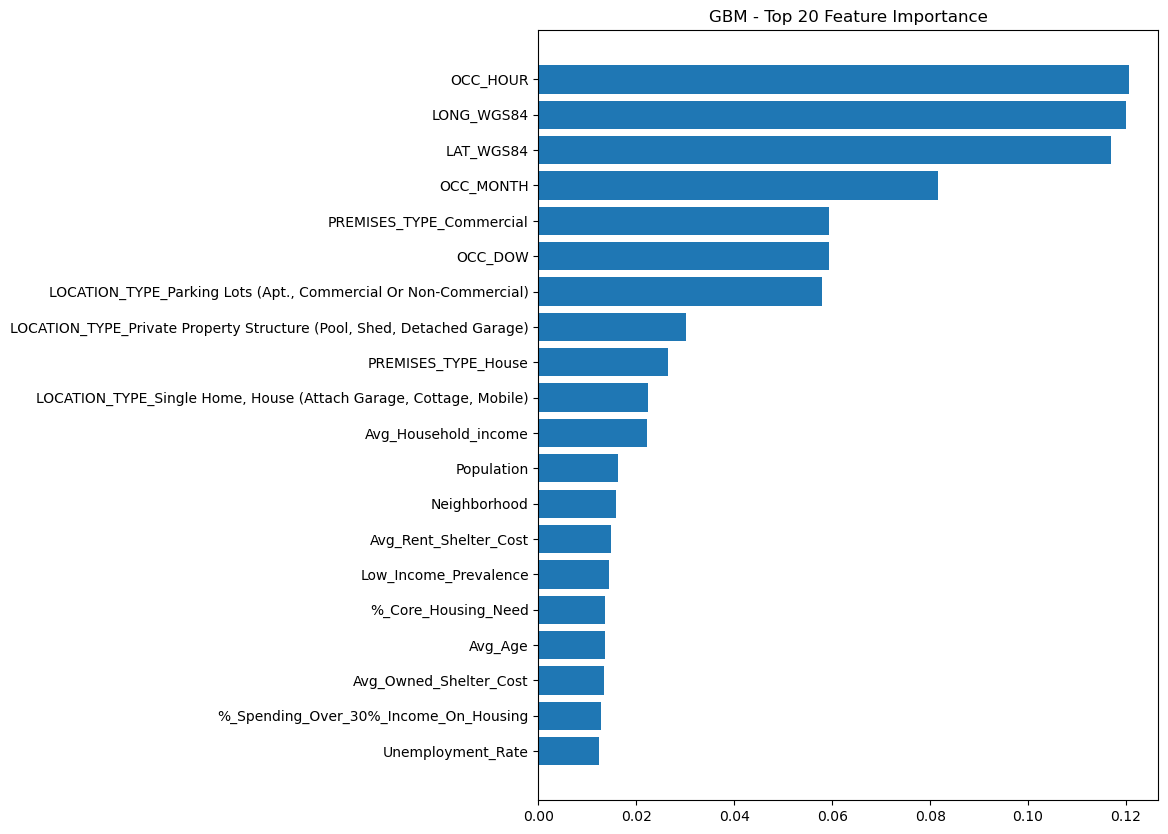

In [44]:
best_gbm_model = gbm_grid.best_estimator_

train_prob = best_gbm_model.predict_proba(X_train)[:,1]
val_prob   = best_gbm_model.predict_proba(X_val)[:,1]
test_prob  = best_gbm_model.predict_proba(X_test)[:,1]

print("GBM AUC:")
print("Train:", roc_auc_score(y_train, train_prob))
print("Val  :", roc_auc_score(y_val, val_prob))
print("Test :", roc_auc_score(y_test, test_prob))

gbm_train_pred  = best_gbm_model.predict(X_train)
gbm_val_pred  = best_gbm_model.predict(X_val)
gbm_test_pred = best_gbm_model.predict(X_test)

gbm_train_acc  = accuracy_score(y_train, gbm_train_pred)
gbm_val_acc  = accuracy_score(y_val, gbm_val_pred)
gbm_test_acc = accuracy_score(y_test, gbm_test_pred)

print("GBM Accuracy:")
print(f"Train Accuracy: {gbm_train_acc:.4f}")
print(f"Validation Accuracy: {gbm_val_acc:.4f}")
print(f"Test Accuracy:       {gbm_test_acc:.4f}")


importances = best_rf_model.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,10))
plt.barh(X.columns[idx][:20][::-1], importances[idx][:20][::-1])
plt.title("GBM - Top 20 Feature Importance")
plt.show()

## High Risk Geo Graph

In [159]:
import geopandas as gpd
#read files
geo = gpd.read_file("C:/Users/Yu-Chieh Lin/Downloads/Neighbourhoods - 4326.geojson")
print(geo.columns)

Index(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'CLASSIFICATION',
       'CLASSIFICATION_CODE', 'OBJECTID', 'geometry'],
      dtype='object')


In [160]:
geo['AREA_SHORT_CODE'] = geo['AREA_SHORT_CODE'].astype(int)

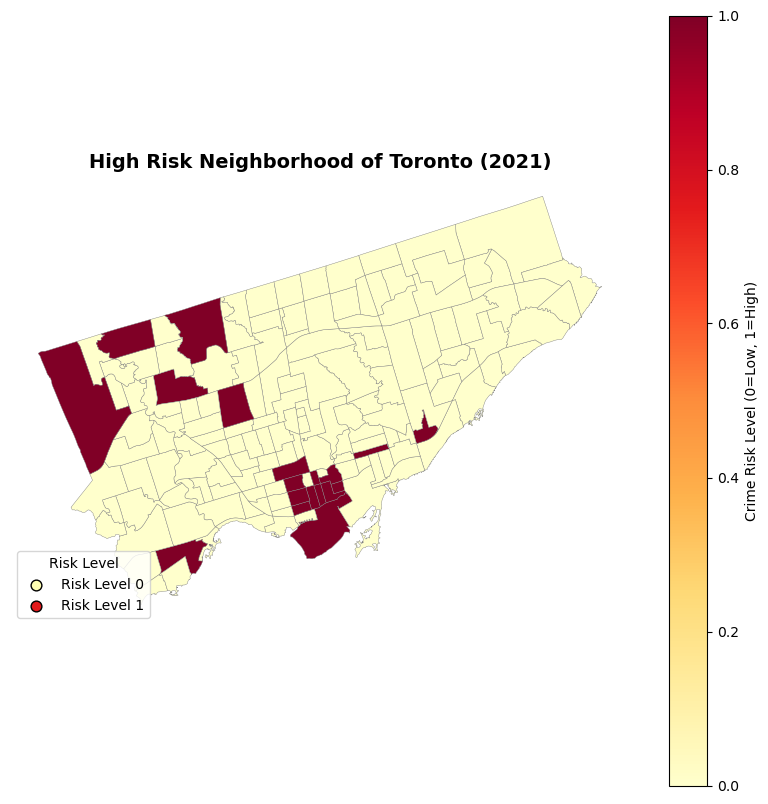

In [161]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Merge geo data and our data
geo_merged = geo.merge(
    merged_df,
    left_on='AREA_SHORT_CODE',  # neighborhood name in geo data
    right_on='Neighborhood', #using neighborhood to merge
    how='left'
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
geo_merged.plot(
    column='High_Risk_Neighborhood',
    cmap='YlOrRd',       
    linewidth=0.3,
    edgecolor='gray',
    legend=True,
    legend_kwds={'label': "Crime Risk Level (0=Low, 1=High)"},
    ax=ax
)

# add the title
ax.set_title("High Risk Neighborhood of Toronto (2021)", fontsize=14, fontweight='bold')
ax.axis('off')

# add label colors
for label, color in [(0, '#ffffb2'), (1, '#e31a1c')]:
    ax.scatter([], [], c=color, label=f'Risk Level {label}', s=60, edgecolors='k')

ax.legend(title='Risk Level', loc='lower left')
plt.show()